In this notebook I illustrate the effectiveness of Weight of Evidence Encoding (`WOEEncoder`) on a simple Logistic Regression model and compare it to other target-based encodings, such as Target Encoding and CatBoost Encoding. 

The bottom line is: it performs quite well, generally better than Target Encoding and Catboost, at least for binary classification problems. Casting `WOEEncoder` on all nominal and cyclical features was enough to get an AUC score of 78.355% on the test set, and replacing `TargetEncoder` with `WOEEncoder` on "stratified" encodings (such as seen in [this notebook by caesarlupum](https://www.kaggle.com/caesarlupum/2020-20-lines-target-encoding) and also in [this clickbait one](https://www.kaggle.com/muhammad4hmed/easily-get-78-5-accuracy)) improved the AUC score from about 78.50% to about 78.56%.

See [this article](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) for a theoretical explanaition, and [this page at Category Encoders](https://contrib.scikit-learn.org/categorical-encoding/woe.html) for documentation. In few words, what this does on a categorical feature $F$ is:
* for each unique value $x,$ consider the corresponding rows in the training set
* compute what percentage of positives is in these rows, compared to the whole set
* compute what percentage of negatives is in these rows, compared to the whole set
* take the ratio of these percentages
* take the natural logarithm of that ratio to get the weight of evidence corresponding to $x,$ so that $WOE(x)$ is either positive or negative according to whether $x$ is more representative of positives or negatives
* NaN's are set to have WOE=0, or according to the `handle_missing` option

For numerical features, it does the same with respect to bins.

In [1]:
import numpy as np 
import pandas as pd 
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

test_features = pd.read_csv("../input/cat-in-the-dat-ii/test.csv")
train_set = pd.read_csv("../input/cat-in-the-dat-ii/train.csv")

train_targets = train_set.target
train_features = train_set.drop(['target'], axis=1)
percentage = train_targets.mean() * 100
print("The percentage of ones in the training target is {:.2f}%".format(percentage))
train_features.head()

The percentage of ones in the training target is 18.72%


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0


# Example

In [2]:
columns = [col for col in train_features.columns if col != 'id']
woe_encoder = ce.WOEEncoder(cols=columns)
woe_encoded_train = woe_encoder.fit_transform(train_features[columns], train_targets).add_suffix('_woe')
train_features = train_features.join(woe_encoded_train)
print(train_features.columns)
woe_encoded_cols = woe_encoded_train.columns
train_features.head()

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'bin_0_woe', 'bin_1_woe', 'bin_2_woe', 'bin_3_woe', 'bin_4_woe',
       'nom_0_woe', 'nom_1_woe', 'nom_2_woe', 'nom_3_woe', 'nom_4_woe',
       'nom_5_woe', 'nom_6_woe', 'nom_7_woe', 'nom_8_woe', 'nom_9_woe',
       'ord_0_woe', 'ord_1_woe', 'ord_2_woe', 'ord_3_woe', 'ord_4_woe',
       'ord_5_woe', 'day_woe', 'month_woe'],
      dtype='object')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8_woe,nom_9_woe,ord_0_woe,ord_1_woe,ord_2_woe,ord_3_woe,ord_4_woe,ord_5_woe,day_woe,month_woe
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,-0.441818,-0.135446,0.314361,-0.096404,0.114060,-0.586839,0.219733,-0.316115,0.080953,-0.294371
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,0.066273,-0.234267,0.314361,0.274988,-0.079506,-0.384647,0.281077,0.299172,0.158142,0.139136
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,-0.097937,0.004441,0.314361,0.001537,-0.412874,0.569908,0.088321,0.136851,-0.163834,0.153646
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,0.227401,0.481353,-0.329994,-0.219820,0.576606,-0.827021,-0.355320,-0.019549,-0.159878,-0.294371
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,0.029980,0.374388,0.314361,0.274988,-0.249094,-0.033965,-0.355320,-0.187883,-0.163834,0.236363


In [3]:
train_features.loc[:, "nom_0_woe"].unique(), train_features.loc[:, "nom_0"].unique()

(array([-0.02743078,  0.05529148, -0.04931574, -0.01238917]),
 array(['Red', 'Blue', 'Green', nan], dtype=object))

Let's see what this does on feature `nom_0`.

In [4]:
df = train_features.copy()
df['target'] = train_targets

overall_number_of_ones = train_targets.sum()
overall_number_of_zeroes = 600000 - overall_number_of_ones
print("There are {} ones and {} zeroes in the training set".format(
    overall_number_of_ones, overall_number_of_zeroes
))

grouped = pd.DataFrame()
grouped['Total'] = df.groupby('nom_0').id.count()
grouped['number of ones'] = df.groupby('nom_0').target.sum()
grouped['number of zeroes'] = grouped['Total'] - grouped['number of ones']

grouped['percentage of ones'] = grouped['number of ones'] / overall_number_of_ones
grouped['percentage of zeroes'] = grouped['number of zeroes'] / overall_number_of_zeroes
grouped['(% ones) > (% zeroes)'] = grouped['percentage of ones'] > grouped['percentage of zeroes']

grouped['weight of evidence'] = df.groupby('nom_0').nom_0_woe.mean()

grouped

There are 112323 ones and 487677 zeroes in the training set


,Total,number of ones,number of zeroes,percentage of ones,percentage of zeroes,(% ones) > (% zeroes),weight of evidence
nom_0,,,,,,,
Blue,205861,40300,165561,0.358787,0.339489,True,0.055291
Green,52601,9458,43143,0.084204,0.088466,False,-0.049316
Red,323286,59183,264103,0.526900,0.541553,False,-0.027431


__Note__: When Percentage of ones is greater than percentage of zeros, then _WoE_ will be positive else negative.

Let's see what it does on another column.

In [5]:
grouped = pd.DataFrame()
grouped['Total'] = df.groupby('month').id.count()
grouped['number of ones'] = df.groupby('month').target.sum()
grouped['number of zeroes'] = grouped['Total'] - grouped['number of ones']

grouped['percentage of ones'] = grouped['number of ones'] / overall_number_of_ones
grouped['percentage of zeroes'] = grouped['number of zeroes'] / overall_number_of_zeroes
grouped['(% ones) > (% zeroes)'] = grouped['percentage of ones'] > grouped['percentage of zeroes']

grouped['weight of evidence'] = df.groupby('month').month_woe.mean()

grouped

,Total,number of ones,number of zeroes,percentage of ones,percentage of zeroes,(% ones) > (% zeroes),weight of evidence
month,,,,,,,
1.0,52154,6352,45802,0.056551,0.093919,False,-0.507162
2.0,40700,4636,36064,0.041274,0.073951,False,-0.582994
3.0,70160,10275,59885,0.091477,0.122796,False,-0.294371
4.0,14614,2389,12225,0.021269,0.025068,False,-0.164011
5.0,68906,12091,56815,0.107645,0.116501,False,-0.079013
6.0,60478,13907,46571,0.123813,0.095496,True,0.259726
7.0,53480,11193,42287,0.099650,0.086711,True,0.139136
8.0,79245,15064,64181,0.134113,0.131606,True,0.018912
9.0,20620,4365,16255,0.038861,0.033331,True,0.153646


# Performance comparison with other encoders

In [6]:
# Define helper function
def logreg_test(cols, encoder):
    df = train_features[cols]
    auc_scores = []
    acc_scores = []
    
    skf = StratifiedKFold(n_splits=6, shuffle=True).split(df, train_targets)
    for train_id, valid_id in skf:
        enc_tr = encoder.fit_transform(df.iloc[train_id,:], train_targets.iloc[train_id])
        enc_val = encoder.transform(df.iloc[valid_id,:])
        regressor = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.6)
        regressor.fit(enc_tr, train_targets.iloc[train_id])
        acc_scores.append(regressor.score(enc_val, train_targets.iloc[valid_id]))
        probabilities = [pair[1] for pair in regressor.predict_proba(enc_val)]
        auc_scores.append(roc_auc_score(train_targets.iloc[valid_id], probabilities))
        
    acc_scores = pd.Series(acc_scores)
    mean_acc = acc_scores.mean() * 100
    print("Mean accuracy score: {:.3f}%".format(mean_acc))
    
    auc_scores = pd.Series(auc_scores)
    mean_auc = auc_scores.mean() * 100
    print("Mean AUC score: {:.3f}%".format(mean_auc))

##########################################
print("Using Weight of Evidence Encoder")
woe_encoder = ce.WOEEncoder(cols=columns)
logreg_test(columns, woe_encoder)

##########################################
print("\nUsing Target Encoder")
targ_encoder = ce.TargetEncoder(cols=columns, smoothing=0.2)
logreg_test(columns, targ_encoder)

##########################################
print("\nUsing CatBoost Encoder")
cb_encoder = ce.CatBoostEncoder(cols=columns)
logreg_test(columns, cb_encoder)

Using Weight of Evidence Encoder
Mean accuracy score: 82.458%
Mean AUC score: 78.498%

Using Target Encoder
Mean accuracy score: 82.445%
Mean AUC score: 78.413%

Using CatBoost Encoder
Mean accuracy score: 82.428%
Mean AUC score: 78.418%


In [ ]:
# df= train_features[columns]
# skf = StratifiedKFold(n_splits=6, shuffle=True).split(df, train_targets)
# for train_id, valid_id in skf:
#     print(train_id.shape[0], valid_id.shape[0])

# Correlation with target

Target-encoded features generally show greater correlation with target that WOE-encoded ones. This is an example where correlation shouldn't be trusted too much as a metric of feature importance.

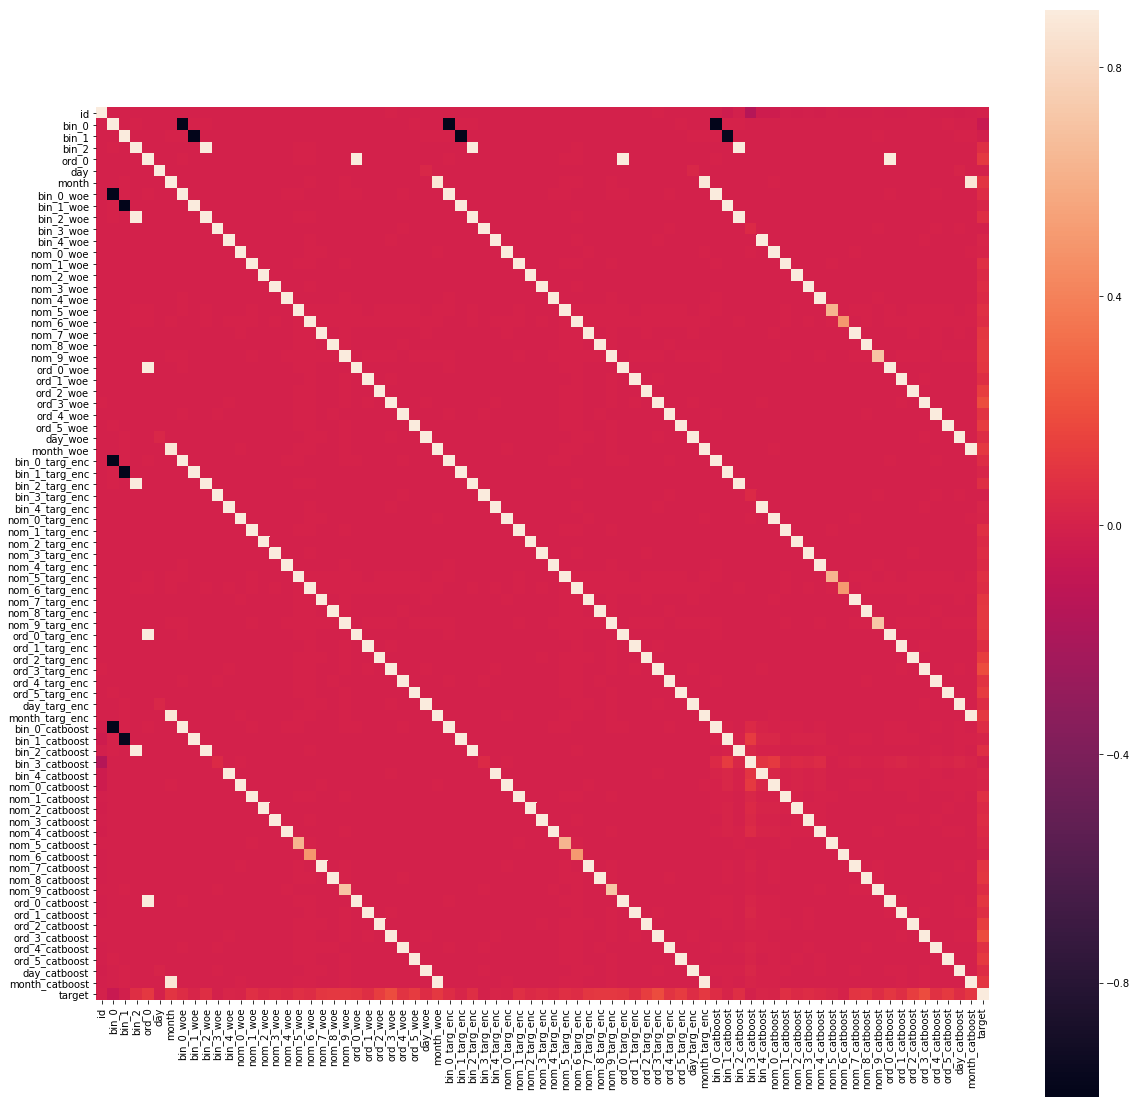

In [7]:
# Encode again, this time on the whole training set. WOEE was done above.
encoder = ce.TargetEncoder(cols=columns, smoothing=0.2)
encoded_train = encoder.fit_transform(train_features[columns], train_targets).add_suffix('_targ_enc')
train_features = train_features.join(encoded_train)

encoder = ce.CatBoostEncoder(cols=columns)
encoded_train = encoder.fit_transform(train_features[columns], train_targets).add_suffix('_catboost')
train_features = train_features.join(encoded_train)

training_set = train_features.copy()
training_set['target'] = train_targets
corrmat = training_set.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, vmax=0.9, square=True)

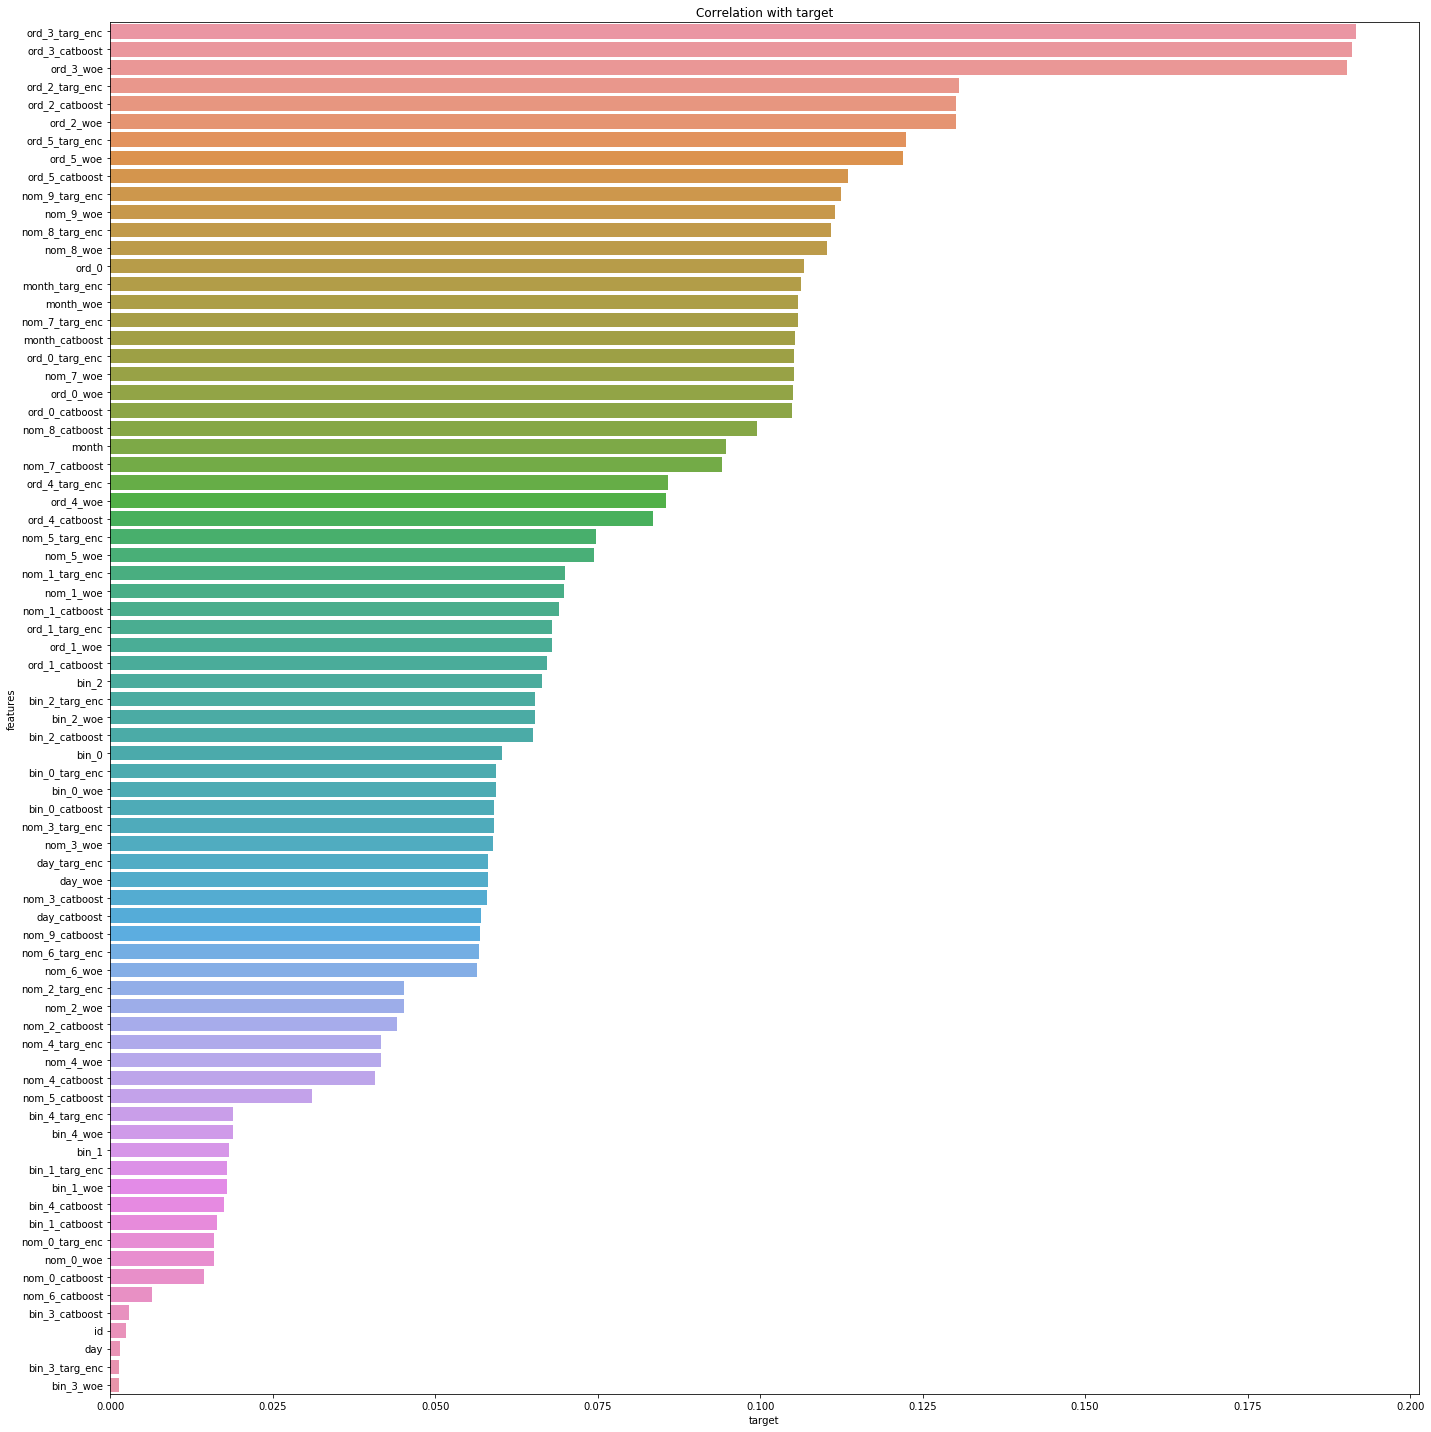

In [8]:
corr_with_target = corrmat['target'].apply(abs).sort_values(ascending=False)
corr_with_target.drop(['target'], inplace=True)
df = pd.DataFrame(data={'features': corr_with_target.index, 'target': corr_with_target.values})
plt.figure(figsize=(20, 20))
sns.barplot(x="target", y="features", data=df)
plt.title('Correlation with target')
plt.tight_layout()
plt.show()

# Other remarks gathered from previous notebooks
* for `day` and `month`, both target encoding and WoE encoding show higher correlation with target than the original labeling and also than the "trigonometrical" encoding
* for binary and ordinal features, WoE encoding alone showed little improvement with respect to the obvious ordinal encodings
* Casting `WOEEncoder` on nominal and cyclical features, and using ordinal encoding for binary and ordinal features resulted in an AUC score of 0.78355 on the test set
* Casting `TargetEncoder` on all features resulted in an AUC score of 0.78302 on the test set

# Using stratified WOE encoding for final output

In [ ]:
# Encoding training data
df = train_features[columns]
print(df.columns)
train_encoded = pd.DataFrame()
#This is Kfold CV encoding to avoid overfitting and data leakage
skf = StratifiedKFold(n_splits=5,shuffle=True).split(df, train_targets)
for tr_in,fold_in in skf:
    encoder = ce.WOEEncoder(cols=columns)
    encoder.fit(df.iloc[tr_in,:], train_targets.iloc[tr_in])
    train_encoded = train_encoded.append(encoder.transform(df.iloc[fold_in,:]),ignore_index=False)

train_encoded = train_encoded.sort_index()

# Encoding test data
#For encoding test data we can use entire train data since we dont fear overfitting for testing or test data. Overfitting comes into picture when training.
encoder = ce.WOEEncoder(cols=columns)
encoder.fit(df, train_targets)
test_encoded = encoder.transform(test_features[columns])

# Fitting
regressor = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.6)
regressor.fit(train_encoded, train_targets)

# Predicting
probabilities = [pair[1] for pair in regressor.predict_proba(test_encoded)]
output = pd.DataFrame({'id': test_features['id'],
                       'target': probabilities})
output.to_csv('submission.csv', index=False)
output.describe()